In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.master("local[*]").appName("SpaceEAssessment").enableHiveSupport().getOrCreate()

Extract data and load into Data Frame

In [2]:
#salesFullDF = spark.read.options(header=True, inferSchema=True).csv("https://eforexcel.com/wp/wp-content/uploads/2020/09/5m-Sales-Records.7z")
salesFullDF = spark.read.options(header=True, inferSchema=True).option("dateFormat","MM/dd/yyyy").csv("5m Sales Records.csv")


Converting Date columns to date type

In [80]:
salesFormatDF= salesFullDF.withColumn('Order Date', to_date(col('Order Date'),'M/d/yyyy')).withColumn('Ship Date',to_date(col('Ship Date'),'M/d/yyyy'))


Removing Spaces in column names

In [81]:
salesFormatDF =salesFormatDF.select([column(col).alias(re.sub("[ ]+","",col)) for col in salesFormatDF.columns])

In [82]:
salesFormatDF.printSchema()

root
 |-- Region: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- SalesChannel: string (nullable = true)
 |-- OrderPriority: string (nullable = true)
 |-- OrderDate: date (nullable = true)
 |-- OrderID: integer (nullable = true)
 |-- ShipDate: date (nullable = true)
 |-- UnitsSold: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- UnitCost: double (nullable = true)
 |-- TotalRevenue: double (nullable = true)
 |-- TotalCost: double (nullable = true)
 |-- TotalProfit: double (nullable = true)



In [87]:
salesFormatDF.count()

5000000

 Write to Parquet By partitioning on OrderDate

In [91]:
#salesFormatDF.write.partitionBy("OrderDate").mode("overwrite").parquet("outpu_data")
#df.write.parquet("output_data")
salesFormatDF.coalesce(1).write.partitionBy("OrderDate").mode("overwrite").parquet("output_data")

Adding Day of week column, this column stores day of column Order Date

In [96]:
salesFormatDF = salesFormatDF.withColumn("OrderDayOfWeek", date_format("OrderDate","EEEE"))

 Summary of Total Revenue by Region per week

In [102]:
salesFormatDF.groupBy("Region", "OrderDayOfWeek").agg(sum("TotalRevenue").alias("SumTotalRevenue"), avg("TotalRevenue").alias("AvgTotalRevenue"),
                                          min("TotalRevenue").alias("Min"), max("TotalRevenue").alias("Max")).show(5, truncate=False)

+---------------------------------+--------------+---------------------+------------------+-----+----------+
|Region                           |OrderDayOfWeek|SumTotalRevenue      |AvgTotalRevenue   |Min  |Max       |
+---------------------------------+--------------+---------------------+------------------+-----+----------+
|Asia                             |Tuesday       |1.3934106350640015E11|1334045.605614171 |9.33 |6682031.73|
|Australia and Oceania            |Tuesday       |7.714961356398991E10 |1328791.1395795713|93.3 |6679358.65|
|Middle East and North Africa     |Monday        |1.1814115786558987E11|1330703.1669567798|18.66|6680026.92|
|Australia and Oceania            |Monday        |7.742678893683987E10 |1334139.5526292734|65.31|6677353.84|
|Central America and the Caribbean|Friday        |1.0296510369907013E11|1334263.362693665 |9.33 |6681363.46|
+---------------------------------+--------------+---------------------+------------------+-----+----------+
only showing top 5 

Unit Cost per Item Type

In [113]:
CostDF=salesFormatDF.groupBy("ItemType").agg(round(avg("UnitPrice"),2).alias("AvgUnitprice"))

In [114]:
Pdf = CostDF.toPandas()

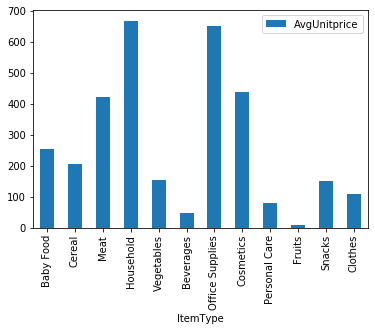

In [117]:
import matplotlib.pyplot as plt
Pdf.plot(x='ItemType', y='AvgUnitprice', kind='bar')

 28 day rolling window sum of the revenue, cost, and profit per sales channe

In [132]:
salesPerDay=salesFormatDF.groupBy('SalesChannel',"OrderDate").agg(sum("TotalRevenue").alias("TotalRevenue"),sum("TotalCost").alias("TotalCost"),sum("TotalProfit").alias("TotalProfit"))

In [129]:
from pyspark.sql.window import Window
windowSpec = Window.partitionBy("SalesChannel").orderBy("OrderDate").rowsBetween(-28, 0)

In [136]:
rollingDF=salesPerDay.select("SalesChannel","OrderDate","TotalRevenue","TotalCost","TotalProfit").withColumn('rollingRevenue',sum("TotalRevenue").over(windowSpec))

In [137]:
rollingDF.show(5)

+------------+----------+-------------------+--------------------+--------------------+--------------------+
|SalesChannel| OrderDate|       TotalRevenue|           TotalCost|         TotalProfit|      rollingRevenue|
+------------+----------+-------------------+--------------------+--------------------+--------------------+
|      Online|2010-01-01|8.834701436600002E8| 6.389838526200001E8|2.4448629104000002E8| 8.834701436600002E8|
|      Online|2010-01-02|7.570476852699999E8|5.1965345471999997E8|2.3739423054999992E8|     1.64051782893E9|
|      Online|2010-01-03|     8.1017477832E8| 5.737954619900001E8|2.3637931632999995E8|     2.45069260725E9|
|      Online|2010-01-04|     8.2862355951E8|      5.8898722454E8|      2.3963633497E8|     3.27931616676E9|
|      Online|2010-01-05|8.072391400100002E8| 5.655486461500001E8|2.4169049386000007E8|4.0865553067700005E9|
+------------+----------+-------------------+--------------------+--------------------+--------------------+
only showing top 5 

a description of how the difference in the order and ship date relates to profit

In [153]:
dateDiffDF=salesFormatDF.select(datediff("ShipDate","OrderDate").alias("DateDiff"),"TotalProfit").groupBy("DateDiff").agg(round(avg("TotalProfit"),2).alias("TotalProfit"))

In [148]:
dateDiffDF.printSchema()

root
 |-- DateDiff: integer (nullable = true)
 |-- TotalProfit: double (nullable = true)



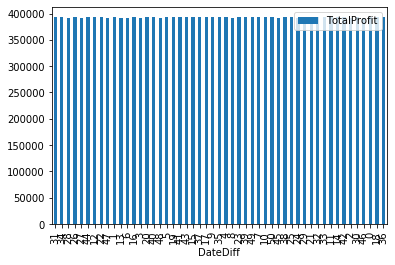

In [154]:
dateDiff = dateDiffDF.toPandas()
dateDiff.plot(x='DateDiff', y='TotalProfit', kind='bar')


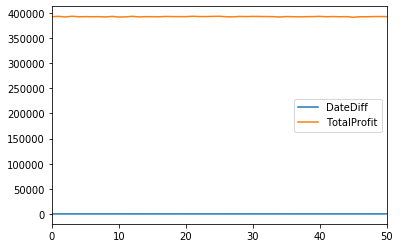

In [156]:
dateDiff.plot.line()